# Dantzig-Wolfe Decomposition Algorithm

Exemple from [Decomposition Techniques in Mathematical Programming](https://link.springer.com/book/10.1007/3-540-27686-6)

it should be emphasized that a linear convex combination of basic feasible solutions of a linear programming problem is a feasible solution of that problem.

## Initial Problem

Decomposable matrix with complicated constraints:

$$
\left (
\begin{matrix}
E^1 & | &     & | &     \\
    & | & E^2 & | &     \\
    & | &     & | & E^3 \\
A^1 & | & A^2 & | & A^3 \\
\end{matrix}
\right )
$$

The problem can be formulated as:
$$
\begin{matrix}
\min c x &\\
s.t. &\\
     & E x & = & b_e \\
     & A x & = & b_a \\
\end{matrix}
$$


## Exemple

$$
\begin{matrix}
\min & 2 x_1 & + & x_2 \\
s.t. 
\end{matrix}

\begin{equation}
  \text{Easy constraints} =
    \begin{cases}
     &   x_1 &   &      & \le &  5 \\
     &       &   &  x_2 & \le &  5 \\
    \end{cases}       
\end{equation}

\begin{equation}
  \text{Coupling constraints} =
    \begin{cases}
     &   x_1 & + &  x_2 & \le &  9 \\
     &   x_1 & - &  x_2 & \le &  4 \\
     &  -x_1 &   & -x_2 & \le & -2 \\
     & -3x_1 &   & -x_2 & \le & -3 \\
    \end{cases}       
\end{equation}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo

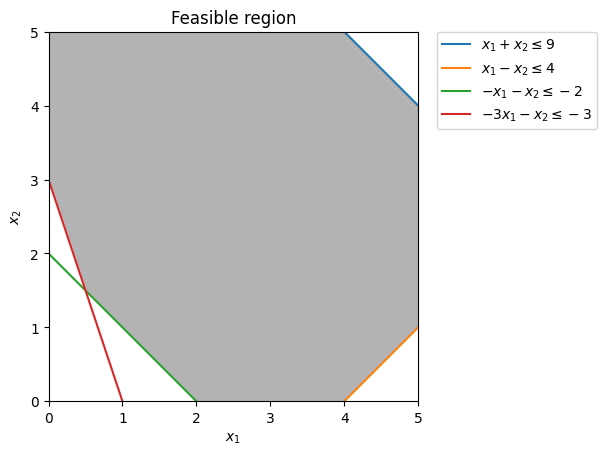

In [2]:
def plot_feasible_region():
    d = np.linspace(-2,7,2000)
    x1,x2 = np.meshgrid(d,d)
    plt.imshow( ((x1<=5) & (x2<=5) & (x1+x2<=9) & (x1 - x2<=4) & (-x1 - x2<=-2) & (-3*x1-x2<=-3)).astype(int) , 
                    extent=(x1.min(), x1.max(), x2.min(), x2.max()),origin="lower", cmap="Greys", alpha = 0.3);

def plot_constraints():
    x1 = np.linspace(-1, 6, 2000)
    x2 = np.linspace(-1, 6, 2000)
    # x1 + x2 <= 9
    x2_a = 9 - x1
    # x1 - x2 <= 4
    x2_b = x1 - 4
    # -x1 - x2 <= -2
    x2_c = 2 - x1
    # -3x1 - x2 <= -3
    x2_d = 3 - 3 * x1

    # Make plot
    plt.plot(x1, x2_a, label=r'$  x_1 +  x_2 \leq  9$')
    plt.plot(x1, x2_b, label=r'$  x_1   -x_2 \leq  4 $')
    plt.plot(x1, x2_c, label=r'$ -x_1   -x_2 \leq -2$')
    plt.plot(x1, x2_d, label=r'$-3x_1   -x_2 \leq -3$')
    plt.xlim(0,5)
    plt.ylim(0,5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title("Feasible region")


plot_feasible_region()
plot_constraints()

We want to find extreme points of the feasible regions.

To do so:

 - Find extrem points of the relaxed problem
 - Find extrem points of the complicated problem as a convex combinaison of the previous extrem points

The relaxed problem of the example is:

$$
\begin{matrix}
\min & 2 x_1 & + & x_2 \\
s.t. \\
     &   x_1 &   &      & \le &  5 \\
     &       &   &  x_2 & \le &  5 \\
\end{matrix}
$$

## Step 0 : Initialization

Obtain extrem points of the feasible regions. Solve the relaxed problems with arbitrary coefficients in the objective functions.

### First resolution

$$
\begin{matrix}
\min & - x_1 &   & -x_2 \\
s.t. \\
     &   x_1 &   &      & \le &  5 \\
     &       &   &  x_2 & \le &  5 \\
\end{matrix}
$$

 - Extreme point 0: $(x_1, x_2) = (5,5)$
 - $z^{(0)} = 2 x_1 + x_2 = 15$
 - $r^{(0)}_1 = x_1 + x_2 = 10$
 - $r^{(0)}_2 = x_1 - x_2 = 0$ 
 - $r^{(0)}_3 = -x_1 - x_2 = -10$
 - $r^{(0)}_4 = -3x_1 - x_2 = -20$
 

### Second resolution

$$
\begin{matrix}
z^{(1)} = \min & -2x_1 & + &  x_2 \\
s.t. \\
     &   x_1 &   &      & \le &  5 \\
     &       &   &  x_2 & \le &  5 \\
\end{matrix}
$$

 - Extreme point 0: $(x_1, x_2) = (5,0)$
 - $z^{(0)} = 2 x_1 + x_2 = 10$
 - $r^{(0)}_1 = x_1 + x_2 = 5$
 - $r^{(0)}_2 = x_1 - x_2 = 5$ 
 - $r^{(0)}_3 = -x_1 - x_2 = -5$
 - $r^{(0)}_4 = -3x_1 - x_2 = -15$


In [3]:
solver = pyo.SolverFactory('cbc', validate=False)

## Step 1 : Master problem

We want to find a **convex** combinaison of K solutions of the relaxed problem that satisfies the master problem.

$$
\begin{matrix}
\min & \sum_{i=1}^{i=K} z^{(i)} u_i \\
s.t. \\
     & \sum_{i=1}^{i=K} u_i & = & 1 & : & \sigma\\
     & \sum_{i=1}^{i=K} r^{(i)}_j * u_i & \leq & b_j & : & \lambda_j & j = 1..R \\
\end{matrix}
$$

From the resolution, we get the value of the dual variables $\sigma$ and $\lambda_j$.

In [4]:
def solve_master_problem(z, b, r):
    model = pyo.ConcreteModel()
    model.set_solutions = pyo.RangeSet(0, len(z) - 1)
    model.set_coupling_constraints = pyo.RangeSet(0, len(b) - 1)
    model.u = pyo.Var(model.set_solutions, within=pyo.NonNegativeReals, bounds=(0, 1))
    model.objective = pyo.Objective(expr=pyo.sum_product(z, model.u), sense=pyo.minimize)
    model.convex_constraint = pyo.Constraint(expr=pyo.summation(model.u) == 1)
    model.coupling_constraints = pyo.Constraint(model.set_coupling_constraints, rule=lambda _model, j: pyo.sum_product(r[j], model.u) <= b[j])
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    solver.solve(model)
    
    m_k = [sum([m_j[i] * pyo.value(model.u[j]) for j, m_j in enumerate(M)]) for i in range(2)]
    # z_k = pyo.value(model.objective)
    # r_k = [sum([A[j][i] * m[i] for i in range(0, 2)]) for j in range(len(b))]
    return pyo.value(model.dual[model.convex_constraint]), [
        pyo.value(model.dual[model.coupling_constraints[0]]),
        pyo.value(model.dual[model.coupling_constraints[1]]),
        pyo.value(model.dual[model.coupling_constraints[2]]),
        pyo.value(model.dual[model.coupling_constraints[3]]),
    ], m_k

## Step 2 : Relaxed problem

Now, we want to minimize the objective found. Let's suppose that we have a new solution of the relaxed problem.

The LP can be written as:
$$
\begin{matrix}
\min & \color{red} z * u + \sum_{i=1}^{i=K} z^{(i)} u_i \\
s.t. \\
     & \color{green} 1 * u + \sum_{i=1}^{i=K} u_i & = & 1 & : & \sigma\\
     & \color{blue}{r_j} * u + \sum_{i=1}^{i=K} r^{(i)}_j * u_i & \leq & b_j & : & \lambda_j & j = 1..R \\
\end{matrix}
$$

With u, the new variable added to master problem. We have:

$$
z = \sum_i c_i x_i \\
r_j = \sum_i a_{ij} x_i
$$

The reduction of the objective depends on the reduced cost of the new variable, which is equals to:

$$
rc_u = \color{red} z - \sum_j \color{blue}{r_j} \lambda_j - \color{green} 1 * \sigma \\
rc_u = \sum_i c_i x_i - \sum_j \lambda_j (\sum_i a_{ij} x_i) - \sigma \\
rc_u = \sum_i x_i (c_i - \sum_j \lambda_j a_{ij}) - \sigma \\
$$

We need to find the best/minimal reduce cost to minimize the objective of the master problem. $\sigma$ is a constant, which gives us the following problem to solve:

$$
\begin{matrix}
\min & \sum (c_j - \sum \lambda_j aij) x_e \\
s.t. \\
     & E x & \leq & b_e
\end{matrix}
$$

From the relaxed problem, we get a new extrem point, objective z and value of complicated constraint to use in the convex combinaison

In [5]:
c = [2, 1]

def solve_relaxed_problem(E, be, 𝜆, A, c=c):
    number_of_coupling_constraints = len(𝜆)
    number_of_variables = len(c)
    # Reduced Costs
    rc = [c[i] - sum([𝜆[j] * A[j][i] for j in range(number_of_coupling_constraints)]) for i in range(number_of_variables)]
    model = pyo.ConcreteModel()
    model.set_easy_constraints = pyo.RangeSet(0, len(be) - 1)
    model.set_x = pyo.RangeSet(0, number_of_variables - 1)
    model.x = pyo.Var(model.set_x, within=pyo.NonNegativeReals)
    model.objective = pyo.Objective(expr=pyo.sum_product(rc, model.x), sense=pyo.minimize)
    model.easy_constraints = pyo.Constraint(model.set_easy_constraints, rule=lambda _model, j: pyo.sum_product(E[j], model.x) <= be[j])
    solver.solve(model)
    m_k = [pyo.value(model.x[i]) for i in model.set_x]
    z_k = sum([c[i] * m_k[i] for i in range(0, 2)])
    r_k = [sum([A_j[i] * m_k[i] for i in range(0, 2)]) for A_j in A]
    return m_k, z_k, r_k

## Step 3 : Convergence checking

We continue as long as objective can be minimized, so reduced cost < 0 <=> z < σ

In [6]:

E = [
    [1, 0],
    [0, 1],
]

be = [
    5,
    5,
]

A = [
    [ 1,  1],
    [ 1, -1],
    [-1, -1],
    [-3, -1],
]

ba = [
     9,
     4,
    -2,
    -3,
]

# Step 0
m_k_1, z_k_1, r_k_1 = solve_relaxed_problem(E, be, [0,0,0,0], A, c=[-1, -1])
m_k_2, z_k_2, r_k_2 = solve_relaxed_problem(E, be, [0,0,0,0], A, c=[-2, 1])
M = [m_k_1, m_k_2]
assert M == [[5,5], [5, 0]]
z = [sum([c[i] * m[i] for i in range(0, 2)]) for m in M]
assert z == [15, 10]
r = [[sum([A_j[i] * m[i] for i in range(0, 2)]) for m in M] for A_j in A]
assert r == [[10.0, 5.0], [0.0, 5.0], [-10.0, -5.0], [-20.0, -15.0]]

z_k = z[1]
σ = 1e6

optimums = []

# Step 1
while z_k < σ:
    σ, 𝜆, m_p = solve_master_problem(z, ba, r)
    optimums.append(m_p)
    
    m_k, z_k, r_k = solve_relaxed_problem(E, be, 𝜆, A, c=c)
   
    M.append(m_k)
    z.append(z_k)
    
    for j, _r in enumerate(r):
        r[j].append(r_k[j])

σ, π, m_p = solve_master_problem(z, ba, r)
optimums.append(m_p)
print(f"Optimum at {m_p}")

Optimum at [0.5, 1.5]


## Evolution of the feasible region
### After iteration 1

In [7]:
d = np.linspace(-2,7,2000)
x1,x2 = np.meshgrid(d,d)

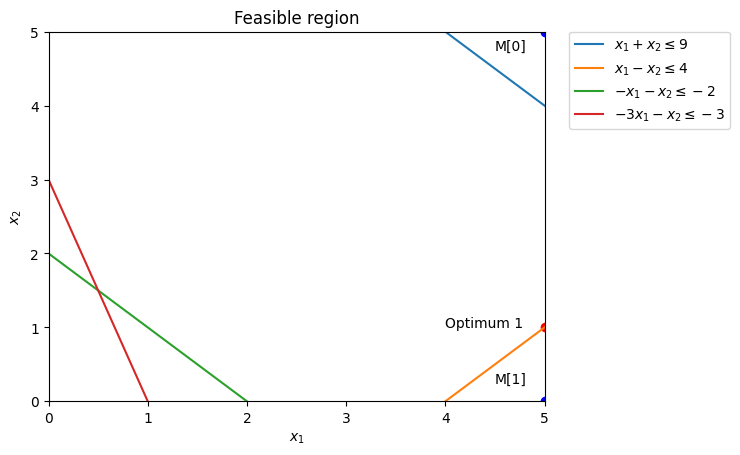

In [8]:
plot_constraints()
m = optimums[0]
plt.scatter(m[0], m[1], color="red")
plt.text(4,1, "Optimum 1")
plt.text(4.5,4.75, "M[0]")
plt.text(4.5,0.25, "M[1]")

for m in M[0:2]:
    plt.scatter(m[0], m[1], color="blue")

### After iteration 2

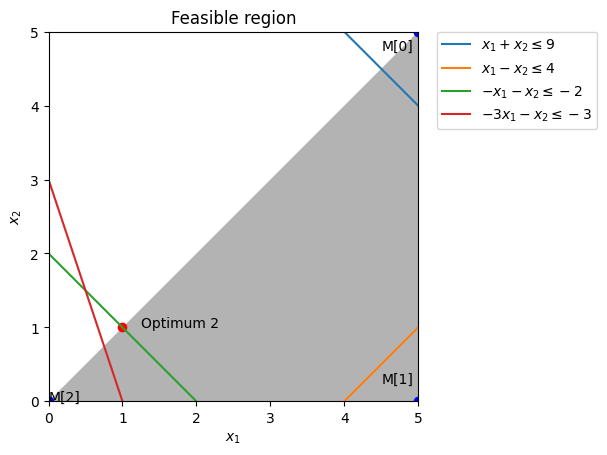

In [9]:
plot_constraints()
m = optimums[1]
plt.scatter(m[0], m[1], color="red")
plt.text(1.25,1, "Optimum 2")

plt.text(4.5,4.75, "M[0]")
plt.text(4.5,0.25, "M[1]")
plt.text(0,0, "M[2]")

for m in M[0:3]:
    plt.scatter(m[0], m[1], color="blue")

plt.imshow( ((x1<=5) & (x2<=5) & (x2-x1<=0)).astype(int) , 
                extent=(x1.min(), x1.max(), x2.min(), x2.max()),origin="lower", cmap="Greys", alpha = 0.3);

### After iteration 3

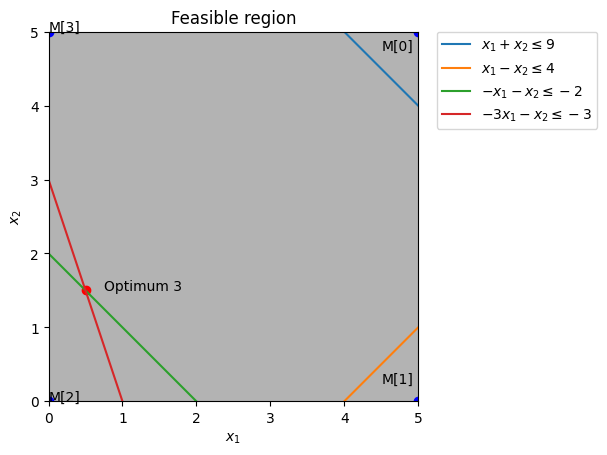

In [10]:
plot_constraints()
m = optimums[2]
plt.scatter(m[0], m[1], color="red")
plt.text(0.75,1.5, "Optimum 3")

plt.text(4.5,4.75, "M[0]")
plt.text(4.5,0.25, "M[1]")
plt.text(0,0, "M[2]")
plt.text(0,5, "M[3]")

for m in M[0:4]:
    plt.scatter(m[0], m[1], color="blue")

plt.imshow( ((x1<=5) & (x2<=5)).astype(int) , 
                extent=(x1.min(), x1.max(), x2.min(), x2.max()),origin="lower", cmap="Greys", alpha = 0.3);

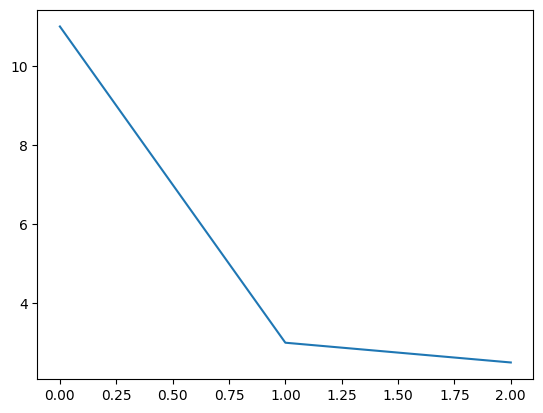

In [14]:
# Evolution of the objective
plt.plot([sum([c[i] * m[i] for i in range(len(c))]) for m in optimums])